This notebook will show how we can perform clustering on categorical data using kmodes algorithm

In [1]:
#import statements

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import adjusted_rand_score

from yellowbrick.cluster import SilhouetteVisualizer

import umap
import umap.plot as uplot

from kmodes.kmodes import KModes

from kneed import KneeLocator


plt.rcParams["figure.figsize"] = (11,7)
sns.set_theme()

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, e

In [2]:
SOY_FEATURE_DESCRIPTION = {
       'date': 'Represents the specific time of soybean sample collection, crucial for understanding seasonal impacts on plant health.',
       'plant-stand': 'Qualitatively assesses the uniformity and health of the plant population, informing about possible early-stage diseases or growth issues.',
       'precip': 'Captures the water level conditions around the sampling time, providing insights into potential water-related stress factors.',
       'temp': 'Reflects the average climatic temperature at the time of observation, crucial for assessing environmental stress conditions.',
       'hail': 'A binary indicator that identifies whether the plant has undergone hail damage, which could affect overall plant health.',
       'crop-hist': 'Denotes the type of crop previously grown in the same field, essential for understanding soil quality and disease carryover risks.',
       'area-damaged': 'Quantifies the spatial extent of observable damage, useful for gauging the disease\'s progression.',
       'severity': 'Categorizes the observable symptoms into different severity levels, aiding in diagnostic precision.',
       'seed-tmt': 'Indicates whether the seeds underwent any treatment before planting, offering clues to possible resistance against diseases.',
       'germination': 'Measures the proportion of seeds that successfully sprouted, a potential early indicator of crop health.',
       'leaves': 'Evaluates leaf condition, which is often the first site of symptom expression in many plant diseases.',
       'lodging': 'A binary flag that notes whether the plant is upright or has fallen, often indicative of structural weakness or disease.',
       'stem-cankers': 'Details the characteristics of stem cankers if present, essential for identifying specific stem diseases.',
       'canker-lesion': 'Documents the type and appearance of canker lesions on the stem, crucial for diagnostic accuracy.',
       'fruiting-bodies': 'A binary indicator of the presence of fruiting bodies, suggesting advanced stages of certain fungal diseases.',
       'external decay': 'Flags the presence of decay on the plant\'s exterior, indicative of severe fungal or bacterial infection.',
       'mycelium': 'A binary indicator for the presence of fungal mycelium, a sign of fungal diseases.',
       'int-discolor': 'Flags internal discoloration, often indicative of systemic infections.',
       'sclerotia': 'Indicates the presence of sclerotial bodies, commonly associated with advanced fungal diseases.',
       'fruit-pods': 'Evaluates the overall health of the fruit pods, crucial for assessing the final yield quality.',
       'roots': 'Assesses root health, providing insights into soil-borne diseases and nutritional deficiencies.'
}

WINE_FEATURES = {
       'alcohol': 'Measures the alcohol content in wine.\n' +
              '- Low (<11%): Lighter, potentially less body.\n' +
              '- Medium (11-14%): Balanced, more body and complexity.\n' +
              '- High (>14%): Fuller-bodied, may feel "hot" if not balanced.',

       'malic_acid': 'Indicates the acidity level from malic acid.\n' +
              '- Low (<0.2 g/L): Less tartness, potentially sweeter.\n' +
              '- High (>0.5 g/L): Tart, "green apple" like acidity.',

       'ash': 'Represents the non-volatile residue in wine.\n' +
              '- Typical range is 1.5-3.0 g/L; doesn\'t directly influence taste.',

       'alcalinity_of_ash': 'Measures the alcalinity of the ash content.\n' +
              '- Low (<15): Higher acidity, crisp.\n' +
              '- High (>25): Lower acidity, might taste flat.',

       'magnesium': 'Indicates the magnesium level in wine.\n' +
              '- Standard range 70-120 ppm; doesn\'t directly affect taste.',

       'total_phenols': 'Represents the total phenolic content.\n' +
              '- Low (<500 mg/L): Less complex, might age poorly.\n' +
              '- High (>1500 mg/L): More complexity, better aging potential.',

       'flavanoids': 'Indicates the flavanoid phenolic content.\n' +
              '- Low (<100 mg/L): Less complexity, poorer aging.\n' +
              '- High (>500 mg/L): More complexity, better aging potential.',

       'nonflavanoid_phenols': 'Measures the non-flavanoid phenolic content.\n' +
              '- Low (<20 mg/L): Better aging potential.\n' +
              '- High (>50 mg/L): Could affect mouthfeel negatively.',

       'proanthocyanins': 'Indicates the proanthocyanin content.\n' +
              '- Low (<200 mg/L): Lighter color.\n' +
              '- High (>500 mg/L): Darker color, more aging potential.',

       'color_intensity': 'Measures the color intensity of the wine.\n' +
              '- Low: Lighter color, often lighter flavor.\n' +
              '- High: Darker color, often bolder flavor.',

       'hue': 'Indicates the hue, or color tint, of the wine.\n' +
              '- Lower : Younger or less quality in red wines.\n' +
              '- High : Older, potentially higher quality especially in red wines.',

       'od280/od315_of_diluted_wines': 'Measures the antioxidant content using absorbance ratio.\n' +
              '- Low (<1.5): Lower antioxidant content.\n' +
              '- High (>3.0): Higher antioxidant content, might indicate better aging potential.',

       'proline': 'Indicates the proline level, an amino acid.\n' +
              '- Low (<500 mg/L): Could indicate less ripe grapes or lower quality.\n' +
              '- High (>1000 mg/L): Could indicate riper grapes or higher quality.'
}



In [3]:
soybean_path = 'soybean_data_use.csv'

soy_df = pd.read_csv(soybean_path)

In [4]:
soy_df

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,sclerotia,fruit-pods,fruit spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class
0,august,normal,gt-norm,norm,no,same-lst-yr,scattered,pot-severe,none,lt-80%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
1,september,normal,gt-norm,norm,yes,same-lst-sev-yrs,low-areas,pot-severe,fungicide,lt-80%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
2,july,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,severe,fungicide,80-89%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
3,october,normal,gt-norm,norm,yes,same-lst-yr,low-areas,pot-severe,none,90-100%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
4,august,normal,gt-norm,norm,yes,same-lst-sev-yrs,scattered,severe,none,lt-80%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
5,september,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,pot-severe,fungicide,90-100%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
6,july,normal,gt-norm,norm,yes,same-lst-two-yrs,low-areas,pot-severe,none,80-89%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
7,july,normal,gt-norm,norm,yes,same-lst-yr,scattered,severe,fungicide,lt-80%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
8,october,normal,gt-norm,norm,yes,same-lst-sev-yrs,scattered,pot-severe,fungicide,80-89%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker
9,october,normal,gt-norm,norm,yes,same-lst-yr,scattered,pot-severe,none,lt-80%,...,absent,norm,dna,norm,absent,absent,norm,absent,norm,diaporthe-stem-canker


In [ ]:
#Checking for any null values
soy_df.isna().sum().sum()

0

In [6]:
unique_vals_series = soy_df.nunique()
unique_vals_series

date               7
plant-stand        2
precip             3
temp               3
hail               2
crop-hist          4
area-damaged       4
severity           2
seed-tmt           2
germination        3
plant-growth       1
leaves             2
leafspots-halo     1
leafspots-marg     1
leafspot-size      1
leaf-shread        1
leaf-malf          1
leaf-mild          1
stem               1
lodging            2
stem-cankers       4
canker-lesion      4
fruiting-bodies    2
external decay     2
mycelium           2
int-discolor       2
sclerotia          2
fruit-pods         2
fruit spots        1
seed               1
mold-growth        1
seed-discolor      1
seed-size          1
shriveling         1
roots              2
class              4
dtype: int64

In [7]:
remove_cols = list(unique_vals_series[unique_vals_series==1].index)
remove_cols

['plant-growth',
 'leafspots-halo',
 'leafspots-marg',
 'leafspot-size',
 'leaf-shread',
 'leaf-malf',
 'leaf-mild',
 'stem',
 'fruit spots',
 'seed',
 'mold-growth',
 'seed-discolor',
 'seed-size',
 'shriveling']

In [8]:
# Extract disease column into new label variable
label = soy_df['class']

# Remove class column and columns having only single unique value
soy_df = soy_df.drop(columns=['class']+remove_cols)

# Print unique value of each label
label.value_counts()

class
phytophthora-rot         17
diaporthe-stem-canker    10
charcoal-rot             10
rhizoctonia-root-rot     10
Name: count, dtype: int64

K-modes clustering implementation 

In [9]:
# Convert categorical features into numerical features using ordinal encoding
encoder = OrdinalEncoder()
encoded_features = encoder.fit_transform(soy_df)

In [10]:
encoded_features

array([[1., 0., 1., 2., 1., 3., 0., 0., 0., 2., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0.],
       [6., 0., 1., 2., 0., 1., 1., 0., 1., 2., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 0.],
       [2., 0., 1., 2., 0., 2., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 0.],
       [5., 0., 1., 2., 0., 3., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0.],
       [1., 0., 1., 2., 0., 1., 0., 1., 0., 2., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0.],
       [6., 0., 1., 2., 0., 2., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0., 0.],
       [2., 0., 1., 2., 0., 2., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 0., 0., 0., 0.],
       [2., 0., 1., 2., 0., 3., 0., 1., 1., 2., 1., 0., 1., 0., 1., 1.,
        0., 0., 0., 0., 0.],
       [5., 0., 1., 2., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 0., 0., 0., 0.],
       [5., 0., 1., 2., 0., 3., 0., 0., 0., 2., 1., 0., 1., 1., 1., 1.,
        0., 0., 0.,

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/umap/plot.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points

<Axes: >

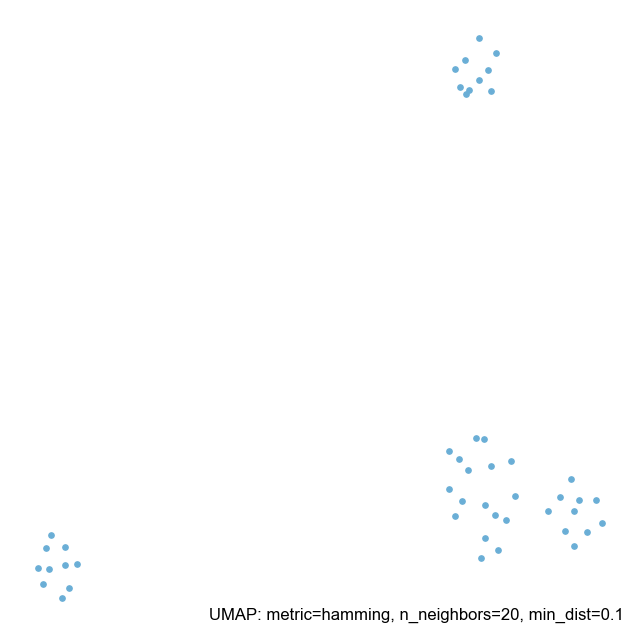

In [11]:
# Embed with umap
umap_model = umap.UMAP(n_neighbors=20, n_components=2, random_state=42, metric='hamming')
umap_emb_data = umap_model.fit_transform(encoded_features)

uplot.points(umap_model)

/opt/anaconda3/envs/venvum/lib/python3.10/site-packages/datashader/transfer_functions/__init__.py:332: RuntimeWarning: invalid value encountered in divide
  scaled_data = (data - span[0])/(span[1] - span[0])


<Axes: >

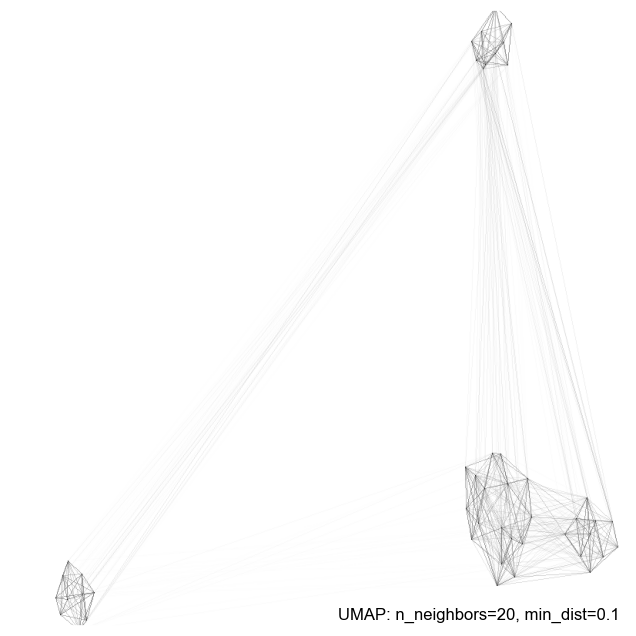

In [12]:
umap.plot.connectivity(umap_model, show_points=True)

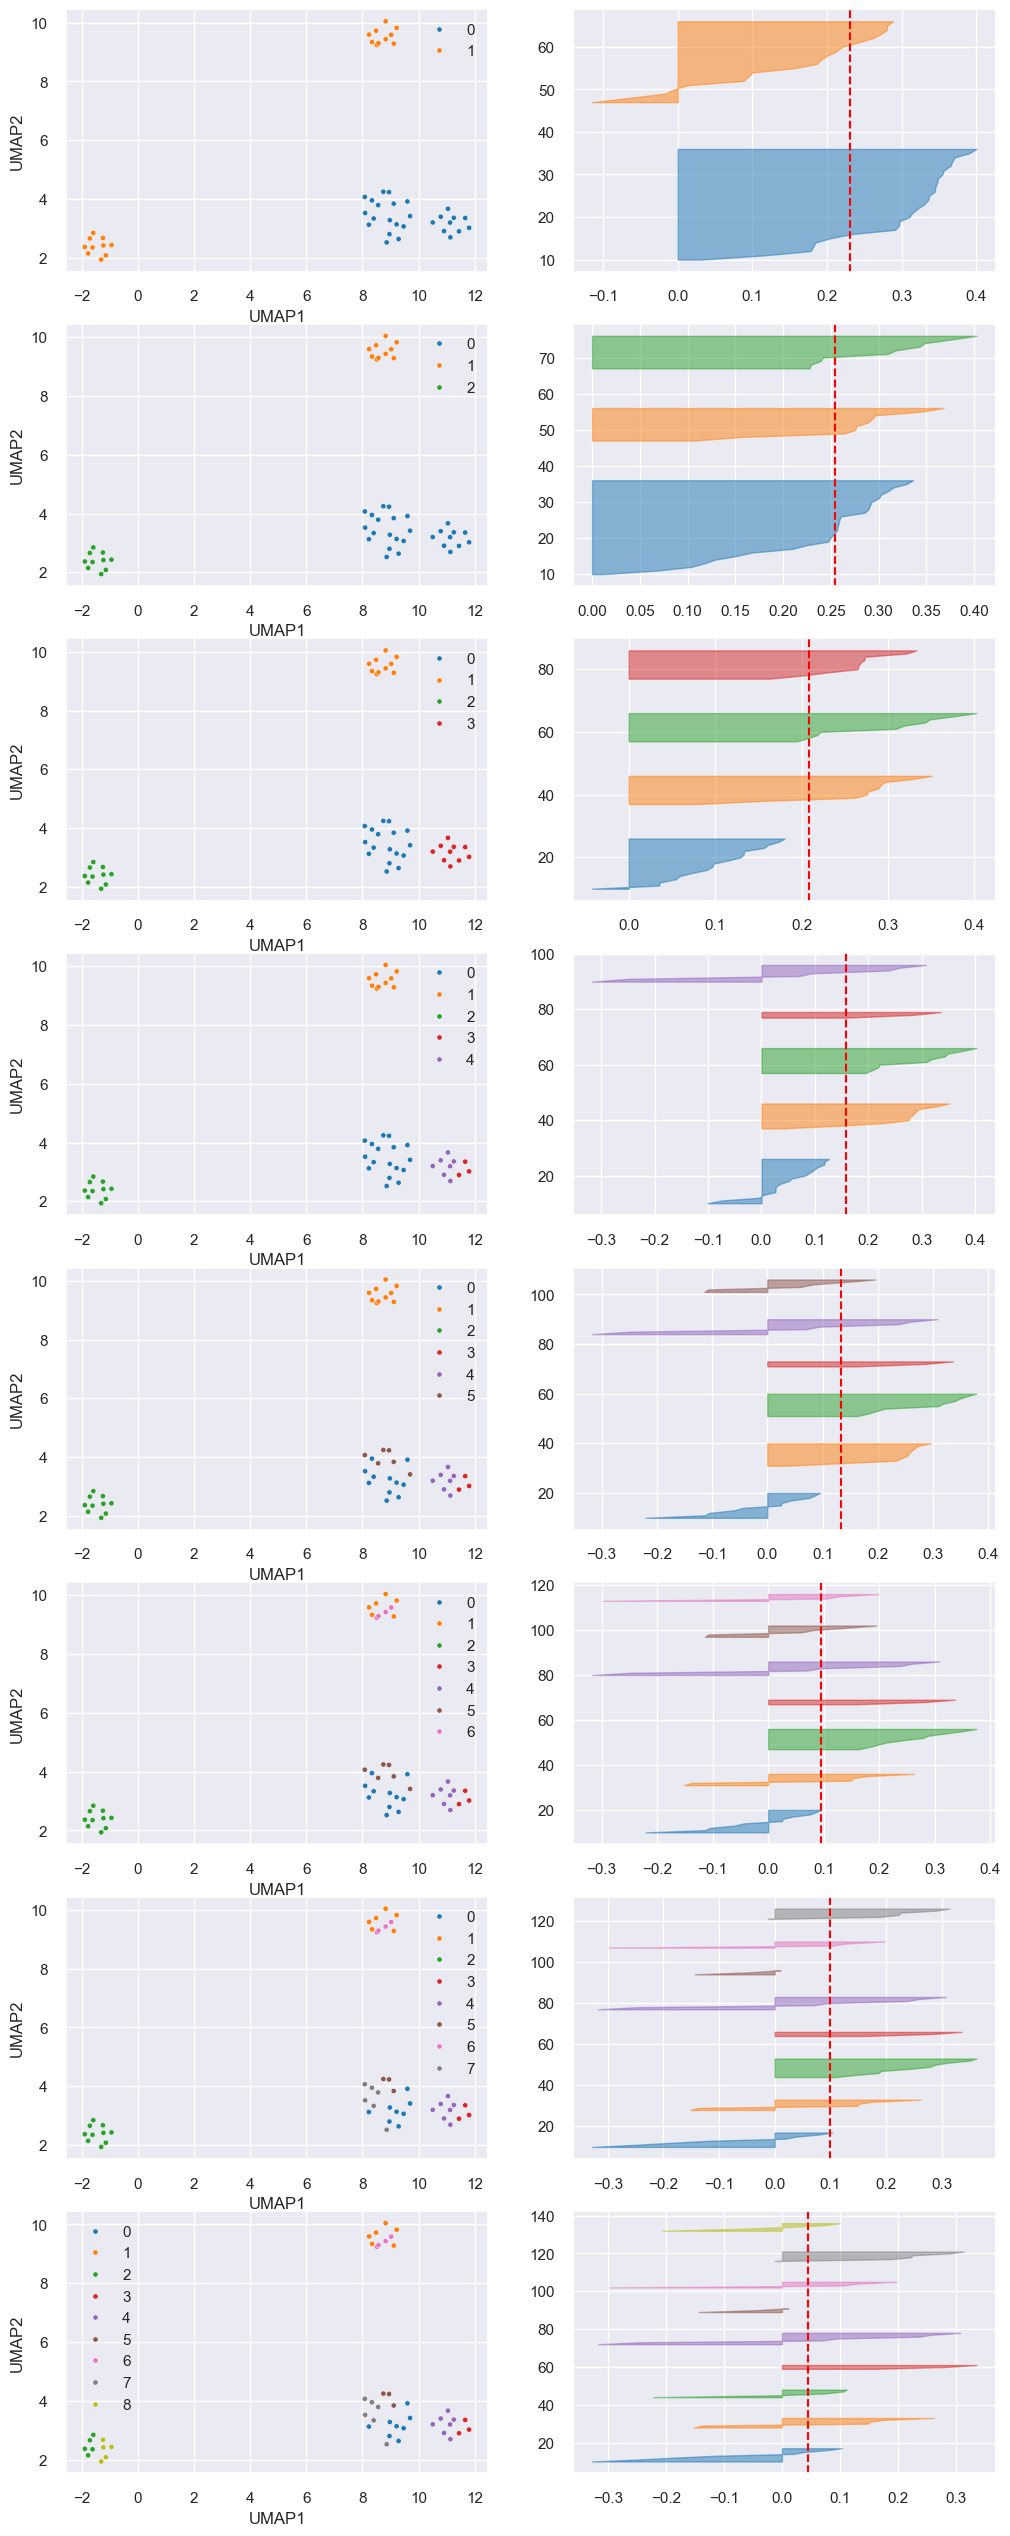

In [13]:
# Perform clustering for multiple k
candidate_k = [2, 3, 4, 5, 6, 7, 8, 9]
tab10 = list(matplotlib.colormaps['tab10'].colors)

cost_list = []
silouethe_score_list = []

fig, axs = plt.subplots(
    len(candidate_k), 2, 
    figsize=(12, 32)
)

cluster_label_dict = {}

for i, num_clust in enumerate(candidate_k):
    
    # Perform clustering for current number of clusters
    kmode = KModes(n_clusters=num_clust)
    kmode.fit_predict(encoded_features)
    
    sns.scatterplot(
        x=umap_emb_data[:,0], 
        y=umap_emb_data[:,1], 
        hue=kmode.labels_, 
        ax=axs[i, 0], 
        s=14, palette='tab10'
    )
    
    axs[i,0].set_xlabel('UMAP1')
    axs[i,0].set_ylabel('UMAP2')

        
    visualizer = SilhouetteVisualizer(
        kmode, 
        is_fitted=True,
        colors=tab10,
        ax=axs[i, 1],
        metric='hamming'
    )
    
    visualizer = visualizer.fit(encoded_features)
    
    silouethe_score_list.append(visualizer.silhouette_score_)
    cost_list.append(kmode.cost_)


Text(0.5, 0, 'Number of clusters')

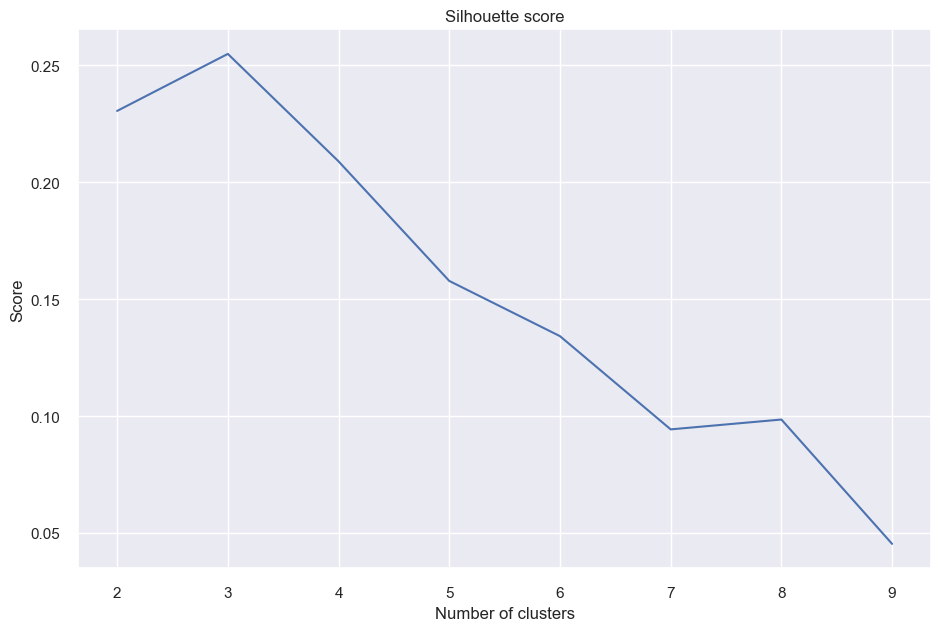

In [14]:
sns.lineplot(x=candidate_k, y=silouethe_score_list)
plt.title('Silhouette score')
plt.ylabel('Score')
plt.xlabel('Number of clusters')

In [16]:
cost_list

[312.0, 236.0, 199.0, 186.0, 170.0, 162.0, 147.0, 134.0]

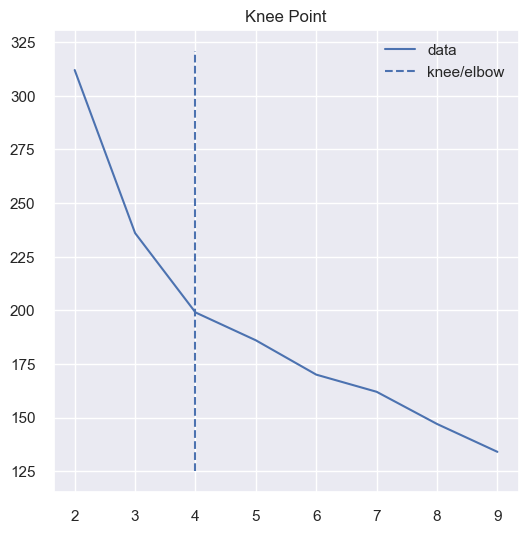

In [15]:
kneedle = KneeLocator(
    candidate_k, 
    cost_list, 
    S=2, 
    curve="convex", 
    direction="decreasing"
)
kneedle.plot_knee()

In [17]:
# Perform clustering for 4 clusters
kmode = KModes(n_clusters=4)
cluster_labels = kmode.fit_predict(encoded_features)

adjusted_rand_score(label, cluster_labels)

1.0

In [19]:
kmode.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=uint16)

### Explore clusters by using stacked bar charts

In [18]:
# Add cluster column to stacked bar chart
soy_df['cluster'] = [str(clust) for clust in kmode.labels_]

proportions = soy_df.groupby(
    'cluster'
)['date'].value_counts(
    normalize=True
).unstack()

proportions

date,april,august,july,june,may,october,september
cluster,,,,,,,
0,0.294118,NaN,0.176471,0.235294,0.294118,NaN,NaN
1,NaN,0.2,0.300000,NaN,NaN,0.3,0.2
2,NaN,0.2,0.200000,NaN,NaN,0.3,0.3
3,0.500000,0.1,0.100000,0.300000,NaN,NaN,NaN




---

### **1. Add Cluster Column to DataFrame**
```python
soy_df['cluster'] = [str(clust) for clust in kmode.labels_]
```

- **Purpose:** Adds a new column, `cluster`, to the `soy_df` DataFrame.  
  - Each cluster label in `kmode.labels_` (generated by the K-Modes clustering algorithm) is converted to a **string** (as explained earlier) and assigned to the new column.
  - This ensures the `cluster` column holds the cluster assignments for each row in the dataset as **categorical identifiers**.

---

### **2. Calculate Proportions of `date` Values for Each Cluster**
```python
proportions = soy_df.groupby('cluster')['date'].value_counts(normalize=True).unstack()
```

#### a) **`groupby('cluster')`:**
- Groups the `soy_df` DataFrame by the `cluster` column.
- Each group corresponds to rows belonging to a specific cluster (e.g., "0", "1", "2", etc.).

#### b) **`['date']`:**
- Within each cluster group, the `date` column is selected for further processing.

#### c) **`.value_counts(normalize=True)`:**
- For each cluster group, calculates the frequency of each unique `date` value.  
- Setting `normalize=True` means the counts are converted to **proportions**, where:
  \[
  \text{Proportion} = \frac{\text{Count of a date value in a cluster}}{\text{Total count of all date values in that cluster}}
  \]

#### d) **`.unstack()`:**
- Reshapes the data so that the `date` values become columns, and the clusters remain as rows.  
- The resulting DataFrame (`proportions`) shows the proportion of each `date` value for every cluster.

---

### **3. Result:**
The `proportions` DataFrame contains a summary table where:
- Rows represent **clusters**.
- Columns represent **unique `date` values**.
- Each cell contains the **proportion of that `date` value within the corresponding cluster**.

---

### **Use Case: Stacked Bar Chart**
- This summary table is likely being prepared for visualization (e.g., a stacked bar chart).
  - Each bar represents a cluster.
  - Segments within each bar represent proportions of different `date` values.
  
By plotting this, you can visually analyze how `date` values are distributed across clusters.


In [20]:
soy_df.head()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,stem-cankers,canker-lesion,fruiting-bodies,external decay,mycelium,int-discolor,sclerotia,fruit-pods,roots,cluster
0,august,normal,gt-norm,norm,no,same-lst-yr,scattered,pot-severe,none,lt-80%,...,above-sec-nde,brown,present,firm-and-dry,absent,none,absent,norm,norm,1
1,september,normal,gt-norm,norm,yes,same-lst-sev-yrs,low-areas,pot-severe,fungicide,lt-80%,...,above-sec-nde,dna,present,firm-and-dry,absent,none,absent,norm,norm,1
2,july,normal,gt-norm,norm,yes,same-lst-two-yrs,scattered,severe,fungicide,80-89%,...,above-sec-nde,dna,present,firm-and-dry,absent,none,absent,norm,norm,1
3,october,normal,gt-norm,norm,yes,same-lst-yr,low-areas,pot-severe,none,90-100%,...,above-sec-nde,brown,present,firm-and-dry,absent,none,absent,norm,norm,1
4,august,normal,gt-norm,norm,yes,same-lst-sev-yrs,scattered,severe,none,lt-80%,...,above-sec-nde,brown,present,firm-and-dry,absent,none,absent,norm,norm,1


Feature - date: 
 Represents the specific time of soybean sample collection, crucial for understanding seasonal impacts on plant health.


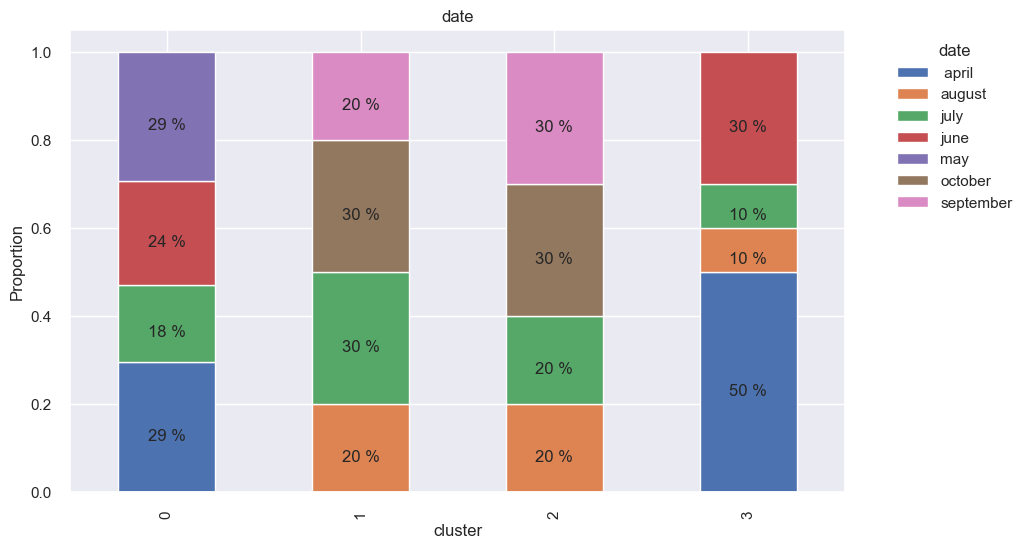

Feature - plant-stand: 
 Qualitatively assesses the uniformity and health of the plant population, informing about possible early-stage diseases or growth issues.


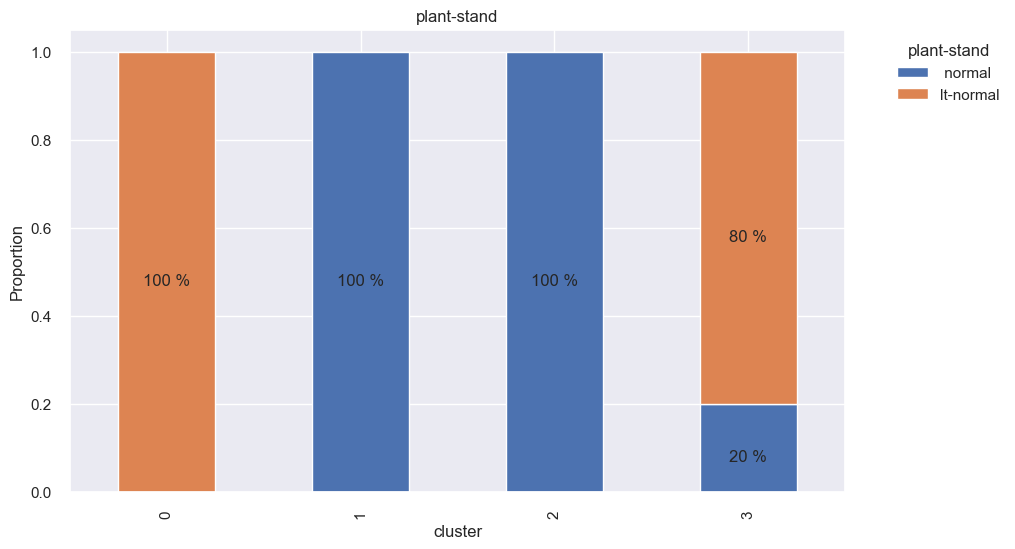

Feature - precip: 
 Captures the water level conditions around the sampling time, providing insights into potential water-related stress factors.


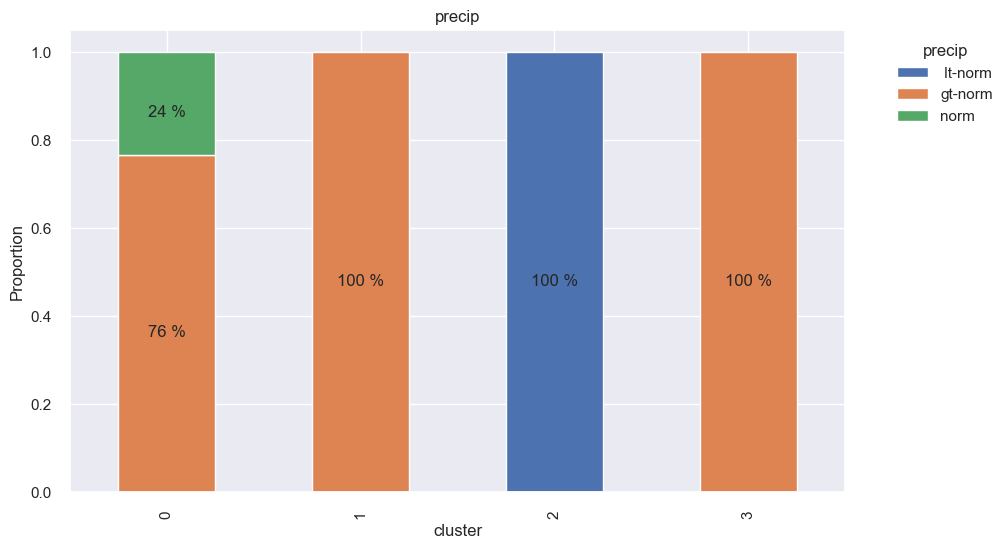

Feature - temp: 
 Reflects the average climatic temperature at the time of observation, crucial for assessing environmental stress conditions.


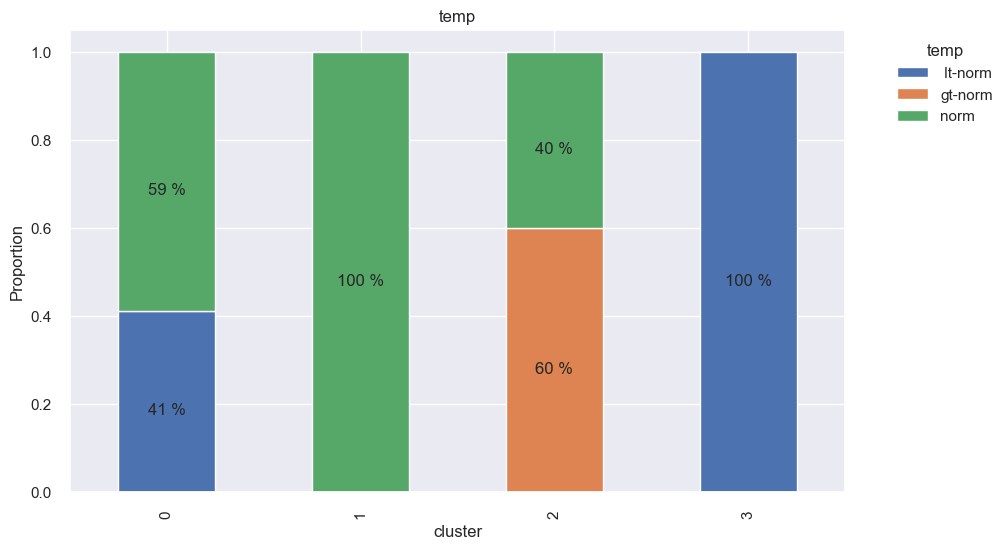

Feature - hail: 
 A binary indicator that identifies whether the plant has undergone hail damage, which could affect overall plant health.


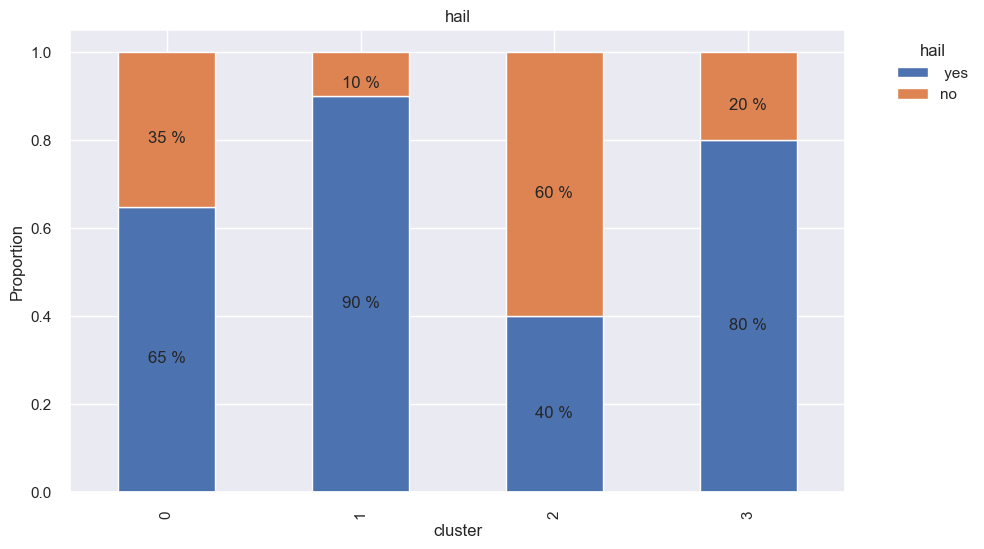

Feature - crop-hist: 
 Denotes the type of crop previously grown in the same field, essential for understanding soil quality and disease carryover risks.


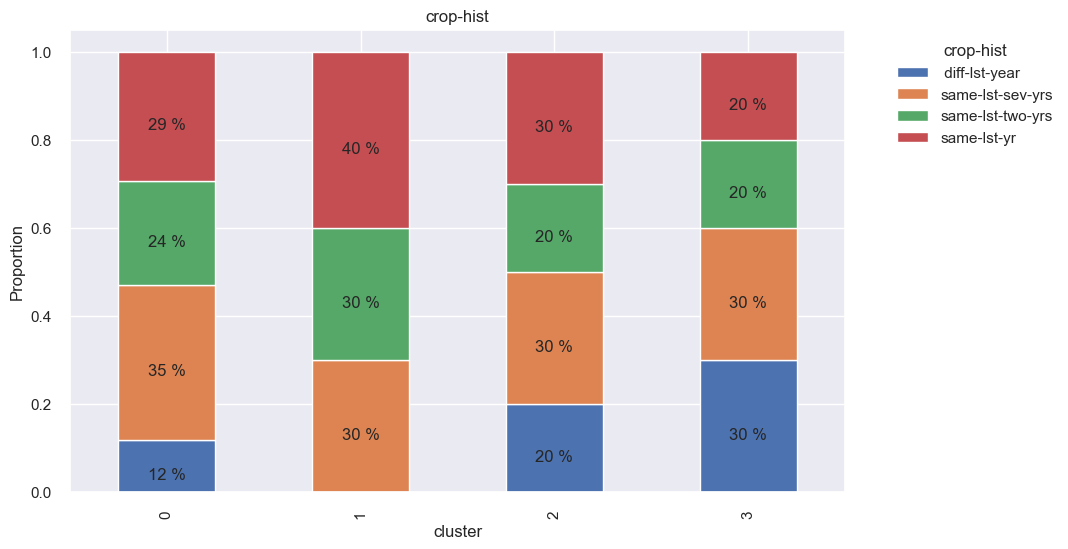

Feature - area-damaged: 
 Quantifies the spatial extent of observable damage, useful for gauging the disease's progression.


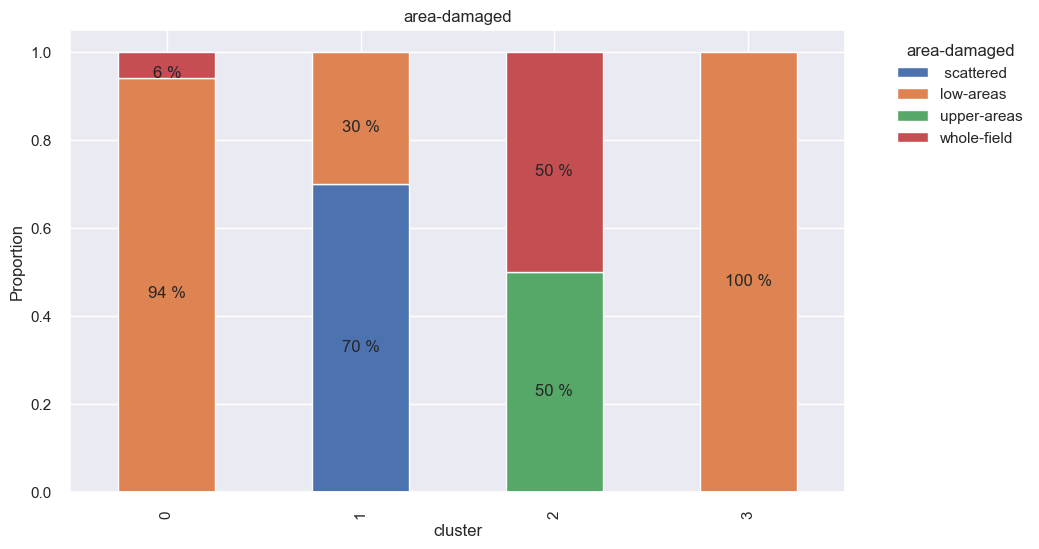

Feature - severity: 
 Categorizes the observable symptoms into different severity levels, aiding in diagnostic precision.


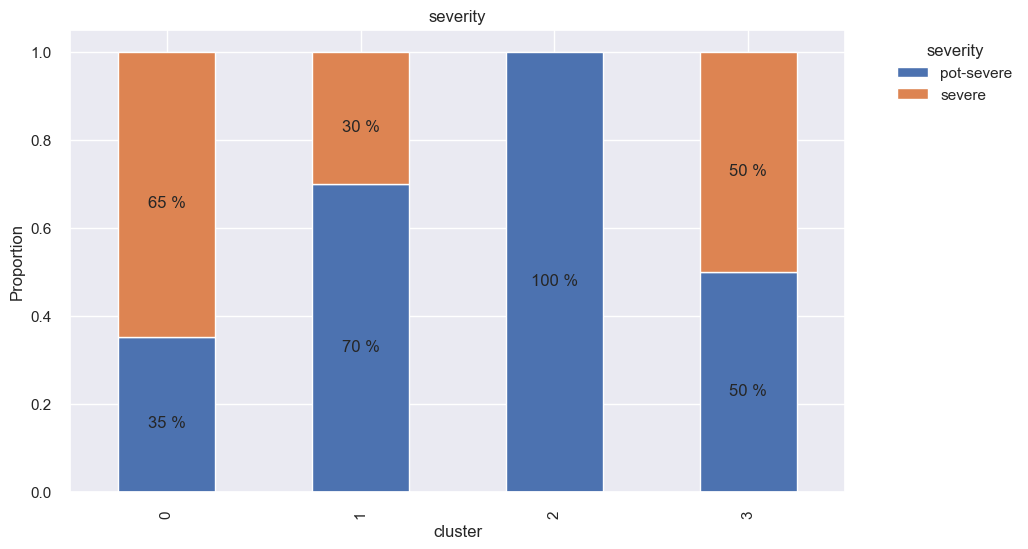

Feature - seed-tmt: 
 Indicates whether the seeds underwent any treatment before planting, offering clues to possible resistance against diseases.


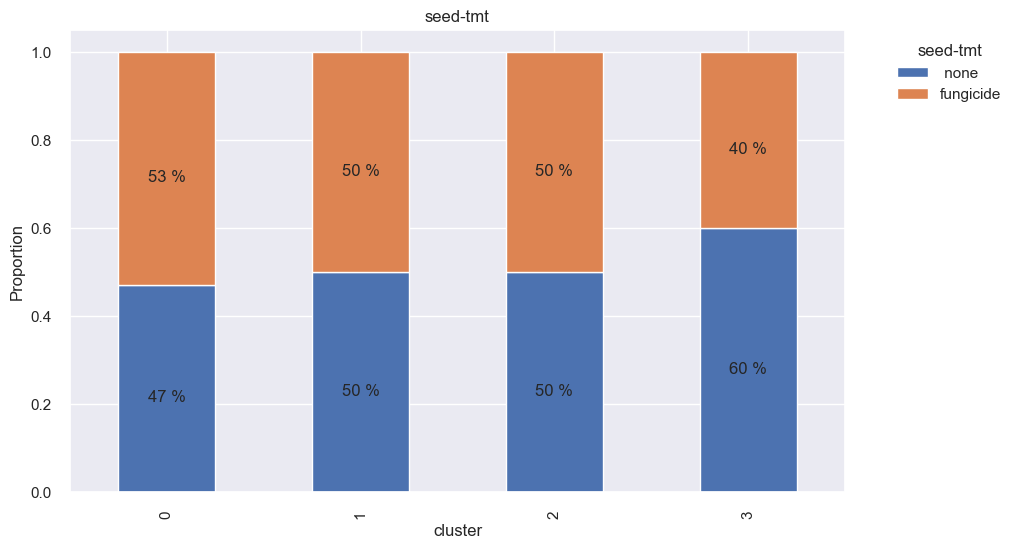

Feature - germination: 
 Measures the proportion of seeds that successfully sprouted, a potential early indicator of crop health.


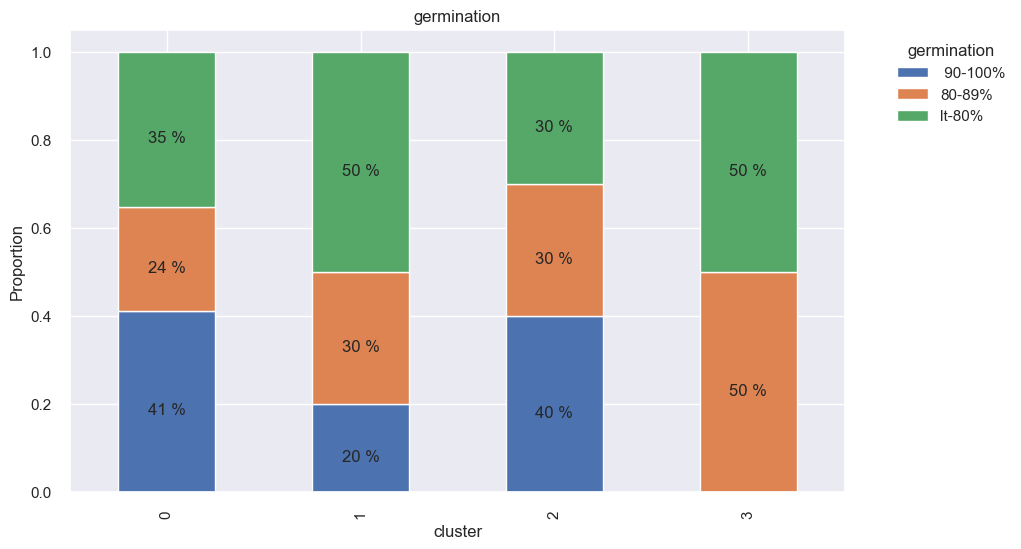

Feature - leaves: 
 Evaluates leaf condition, which is often the first site of symptom expression in many plant diseases.


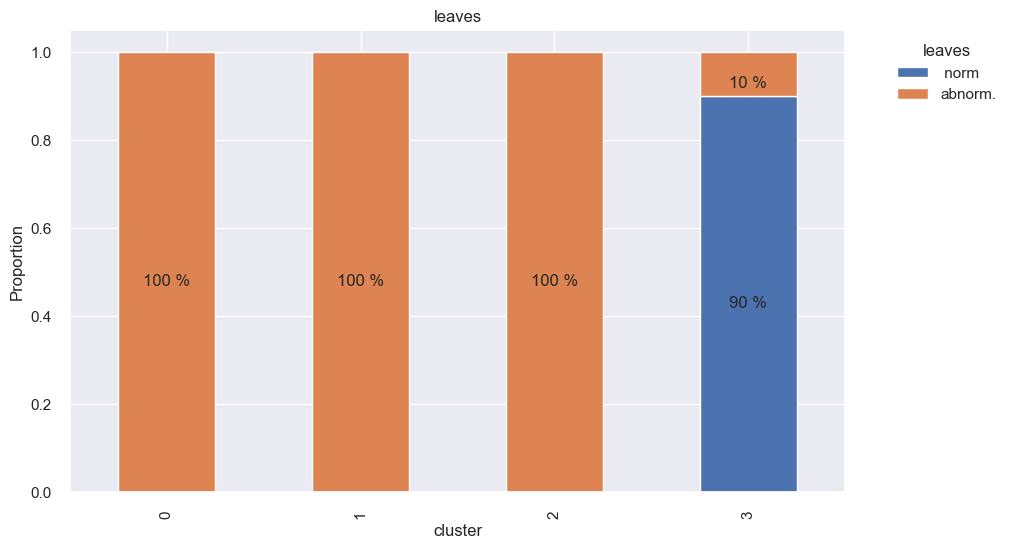

Feature - lodging: 
 A binary flag that notes whether the plant is upright or has fallen, often indicative of structural weakness or disease.


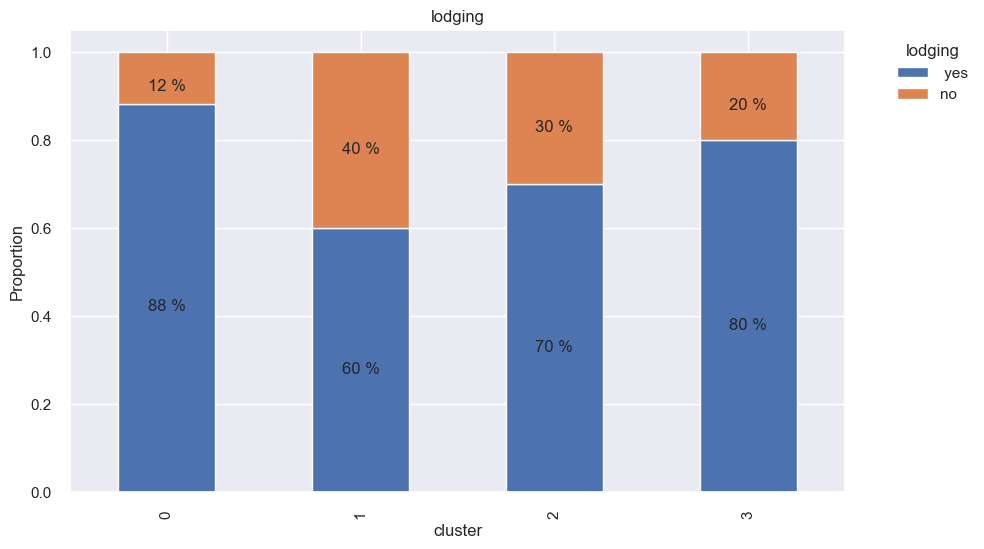

Feature - stem-cankers: 
 Details the characteristics of stem cankers if present, essential for identifying specific stem diseases.


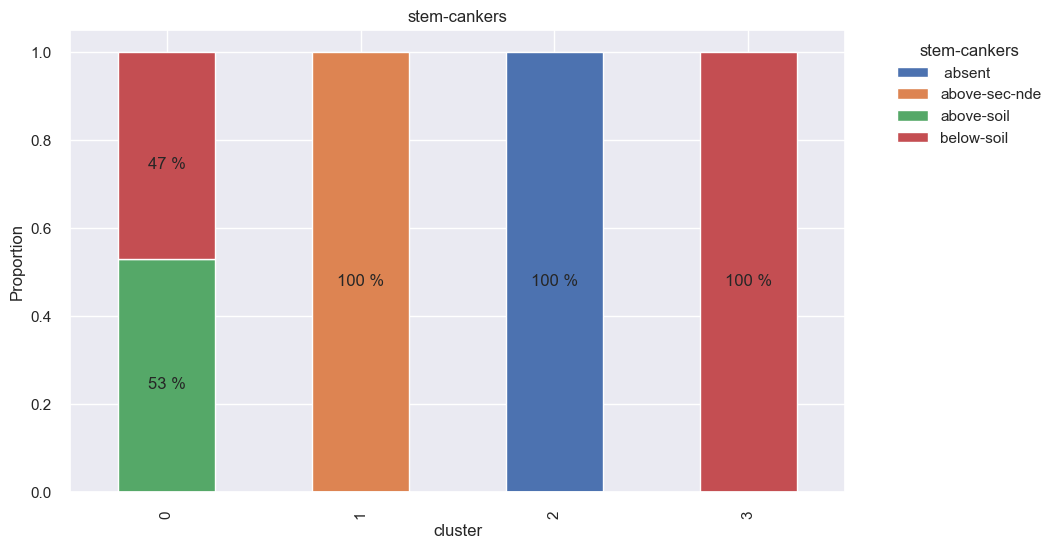

Feature - canker-lesion: 
 Documents the type and appearance of canker lesions on the stem, crucial for diagnostic accuracy.


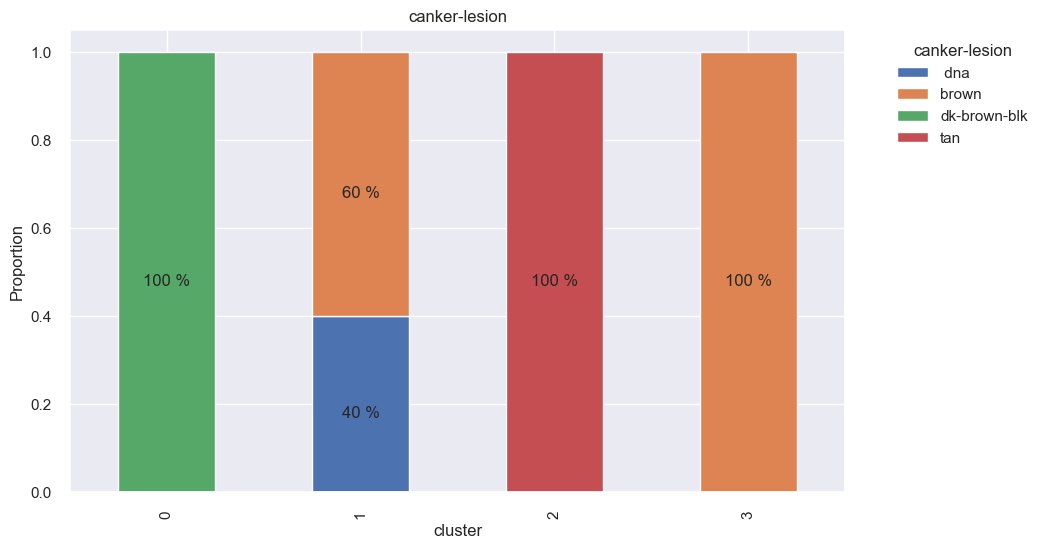

Feature - fruiting-bodies: 
 A binary indicator of the presence of fruiting bodies, suggesting advanced stages of certain fungal diseases.


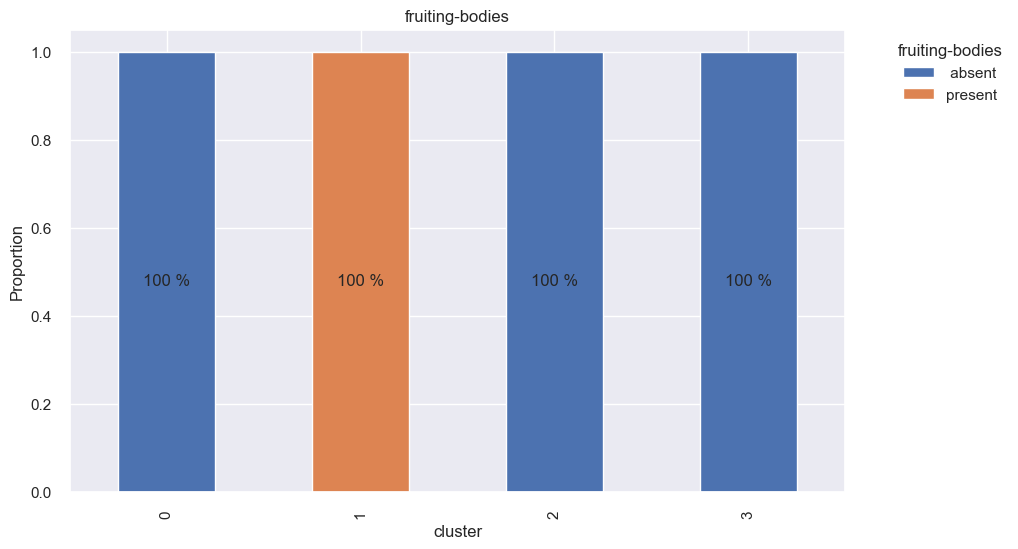

Feature - external decay: 
 Flags the presence of decay on the plant's exterior, indicative of severe fungal or bacterial infection.


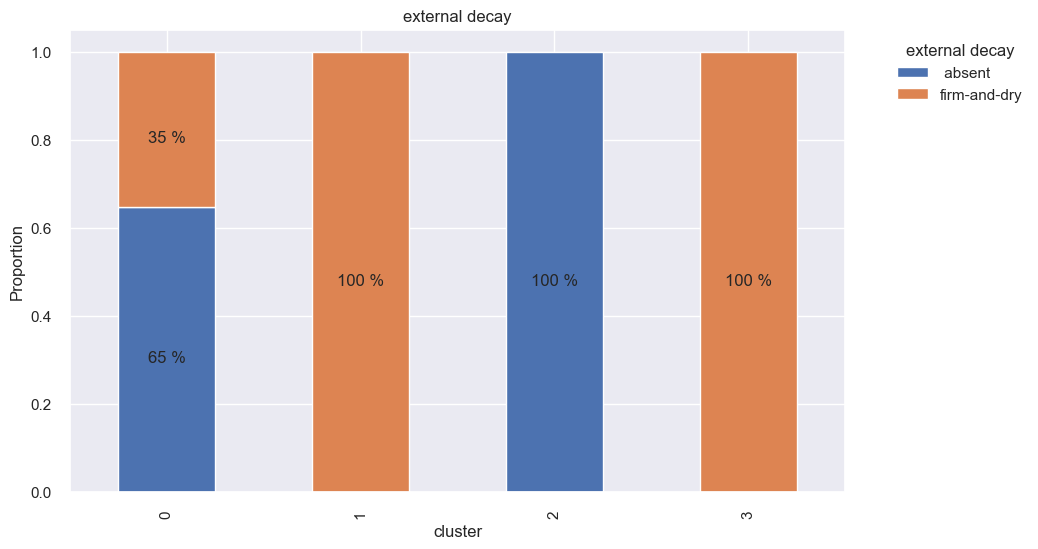

Feature - mycelium: 
 A binary indicator for the presence of fungal mycelium, a sign of fungal diseases.


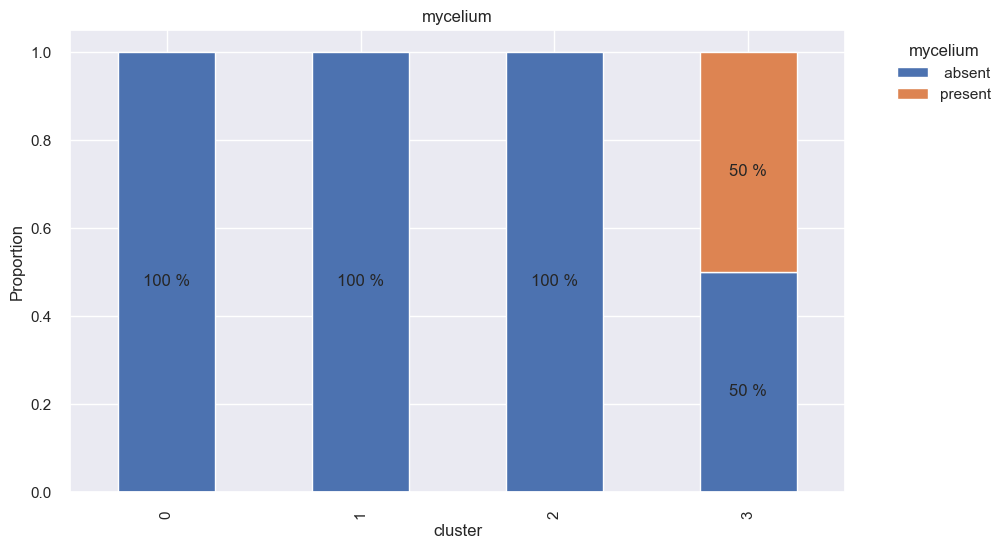

Feature - int-discolor: 
 Flags internal discoloration, often indicative of systemic infections.


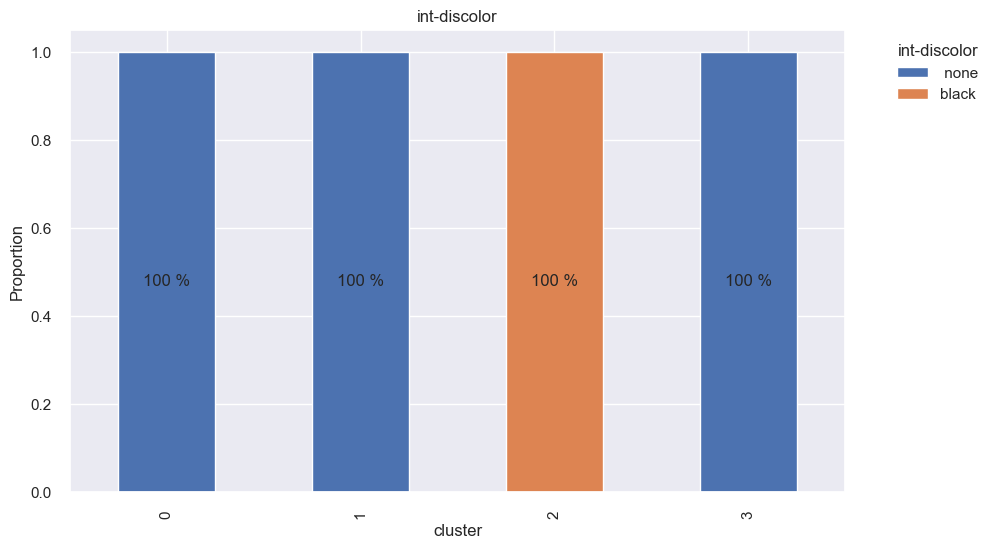

Feature - sclerotia: 
 Indicates the presence of sclerotial bodies, commonly associated with advanced fungal diseases.


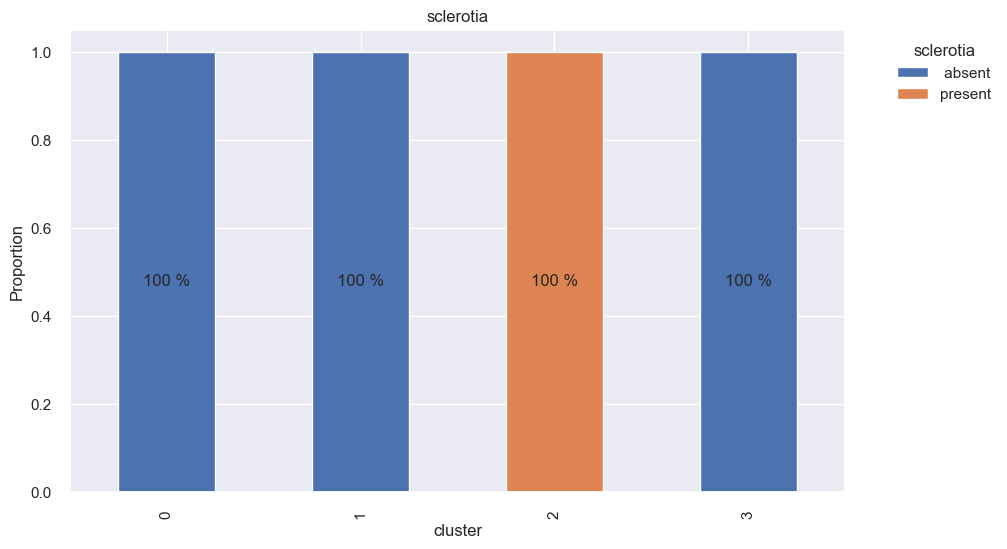

Feature - fruit-pods: 
 Evaluates the overall health of the fruit pods, crucial for assessing the final yield quality.


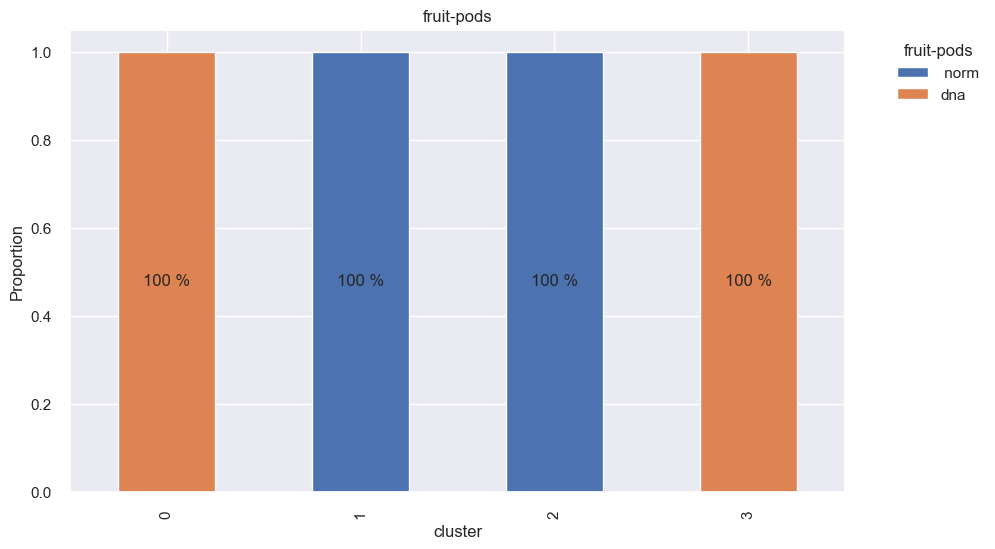

Feature - roots: 
 Assesses root health, providing insights into soil-borne diseases and nutritional deficiencies.


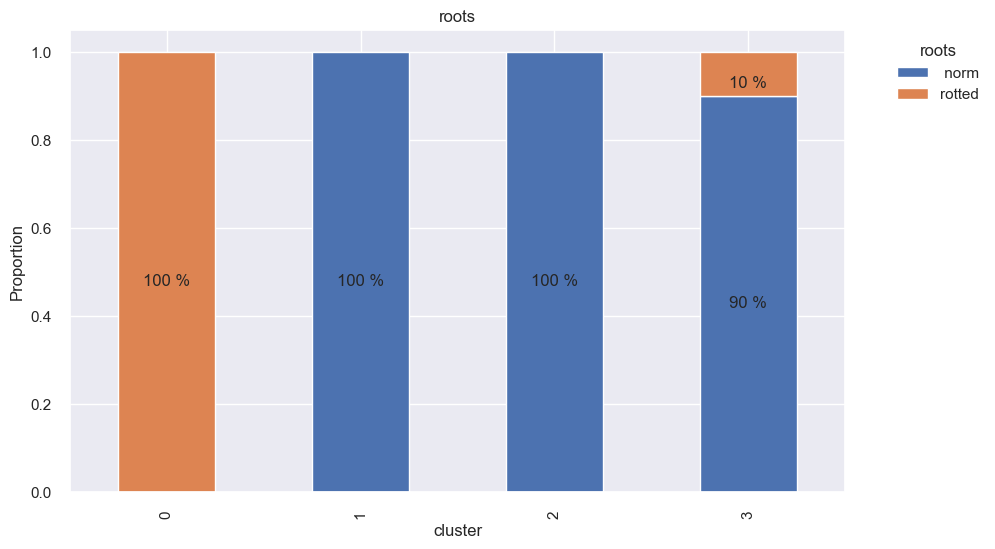

In [21]:
for col in soy_df.columns:
    if col != 'cluster':
        # Calculate proportions
        proportions = soy_df.groupby(
            'cluster'
        )[col].value_counts(
            normalize=True
        ).unstack()
        
        print('Feature - {}: \n {}'.format(col, SOY_FEATURE_DESCRIPTION[col]))
                
        # Create stacked bar plot
        ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
        
        plt.title(col)
        plt.ylabel('Proportion')

        # Add legend
        plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')

        # Get category labels
        category_labels = proportions.columns.tolist()[::-1]

        # Add percentages and category labels to the stacks
        for i, patch in enumerate(ax.patches):
            width, height = patch.get_width(), patch.get_height()
            if height > 0:  # Skip patches with height 0
                x, y = patch.get_xy() 

                ax.text(x+width/2, 
                        y+height/2, 
                        '\n{:.0f} %'.format(height*100), 
                        horizontalalignment='center', 
                        verticalalignment='center')

        plt.show()



---

### **Code Breakdown**

#### **1. Loop through all columns except `cluster`**
```python
for col in soy_df.columns:
    if col != 'cluster':
```
- Iterates through each column in the `soy_df` DataFrame.
- Skips the `cluster` column because it is used as the grouping key and is not a feature being analyzed.

---

#### **2. Calculate Proportions**
```python
proportions = soy_df.groupby('cluster')[col].value_counts(normalize=True).unstack()
```
- Groups the DataFrame by the `cluster` column.
- For the current feature column (`col`), calculates the normalized counts (proportions) of each unique value within each cluster.
- Converts the grouped proportions into a table where:
  - Rows: Clusters.
  - Columns: Unique values in the feature.
  - Values: Proportions of those feature values for each cluster.

---

#### **3. Feature Description**
```python
print('Feature - {}: \n {}'.format(col, SOY_FEATURE_DESCRIPTION[col]))
```
- Prints the description of the current feature (`col`), assuming that `SOY_FEATURE_DESCRIPTION` is a dictionary mapping feature names to their descriptions.

---

#### **4. Create Stacked Bar Plot**
```python
ax = proportions.plot(kind='bar', stacked=True, figsize=(10, 6))
```
- Creates a stacked bar chart:
  - **Bars**: Represent clusters.
  - **Segments in Bars**: Represent proportions of each unique value in the feature.

---

#### **5. Add Plot Titles and Labels**
```python
plt.title(col)
plt.ylabel('Proportion')
plt.legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
```
- Sets the title to the feature name (`col`).
- Labels the y-axis as "Proportion".
- Adds a legend showing the unique values in the feature, positioned outside the plot area.

---

#### **6. Add Percentages and Labels**
```python
category_labels = proportions.columns.tolist()[::-1]
for i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    if height > 0:  # Skip patches with height 0
        x, y = patch.get_xy()
        ax.text(x + width / 2, y + height / 2, 
                '\n{:.0f} %'.format(height * 100), 
                horizontalalignment='center', 
                verticalalignment='center')
```
- Adds percentage labels to each segment in the stacked bars:
  - **`ax.patches`**: Contains all rectangular patches (bars and segments) in the plot.
  - For each segment:
    - Retrieves its dimensions (width and height).
    - Skips segments with height 0 (proportion = 0).
    - Adds text at the center of the segment displaying the percentage value.

---

#### **7. Display the Plot**
```python
plt.show()
```
- Displays the completed plot.

---

### **Purpose**
- **Visual Analysis:** This visualization helps compare how each feature's categories are distributed across clusters.
- **Interpret Clusters:** You can identify patterns in feature distributions and infer the characteristics of clusters.

---
